In [56]:
import pandas as pd
import numpy as np

import seaborn as sns
pal = sns.color_palette()

import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import openpyxl
import plotly.io as pio
pio.renderers.default = "vscode"

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')

from IPython.display import display
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

 # FILE READING, DATA CLEANING AND ANALYSIS ON PRICING

In [75]:
# Import dataset
print("Loading dataset...")

docu =  pd.read_excel('assets/get_around_delay_analysis.xlsx',sheet_name='Documentation')
delay_df = pd.read_excel('assets/get_around_delay_analysis.xlsx',sheet_name='rentals_data')
pricing_df = pd.read_csv('assets/get_around_pricing_project.csv')
print("...Done.")
pd.set_option('display.max_columns', None)

Loading dataset...
...Done.


In [58]:
# Basic stats
print('Basics informations for delay_df')
print()
print("Number of rows : {}".format(delay_df.shape[0]))
print("Number of columns : {}".format(delay_df.shape[1]))
print()

print("Display of dataset: ")
display(delay_df.head())
print()

print("Basics statistics: ")
data_desc = delay_df.describe(include='all')
display(data_desc)
print()
with pd.option_context('display.max_colwidth', None):
    display(docu)
    print()

print("Percentage of missing values: ")

pd.concat([delay_df.isnull().sum(), 100 * delay_df.isnull().sum()/len(delay_df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})


Basics informations for delay_df

Number of rows : 21310
Number of columns : 7

Display of dataset: 


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN



Basics statistics: 


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,21310,21310,16346.000000,1841.000000,1841.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN
freq,NaN,NaN,17003,18045,NaN,NaN,NaN
mean,549712.880338,350030.603426,NaN,NaN,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,NaN,NaN,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,NaN,NaN,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,NaN,NaN,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,NaN,NaN,67.000000,560823.000000,540.000000


,field name,Comment
0,rental_id,Unique identifier of the rental
1,car_id,Unique identifier of the car
2,checkin_type,"Flow used for both checkin and checkout. (ie. access and return the car)\nmobile = rental agreement signed on the owner's smartphone\nconnect = car equiped with the Connect technology , opened by the driver with his smartphone.\nNote: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case"
3,state,canceled means that the rental did not happen (was canceled by the driver or the owner).
4,delay_at_checkout_in_minutes,Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
5,previous_ended_rental_id,id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
6,time_delta_with_previous_rental_in_minutes,"Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)"



Percentage of missing values: 


,Missing Records,Percentage (%)
rental_id,0,0.000000
car_id,0,0.000000
checkin_type,0,0.000000
state,0,0.000000
delay_at_checkout_in_minutes,4964,23.294228
previous_ended_rental_id,19469,91.360863
time_delta_with_previous_rental_in_minutes,19469,91.360863


In [59]:
cols_cat  = [ 'car_id', 'checkin_type',
             'state' ]

cols_num = ['time_delta_with_previous_rental_in_minutes',
            'delay_at_checkout_in_minutes']

On va creer une nouvelle feature 'checkout' pour regrouper les retards

In [60]:
delay_df['checkout'] = pd.cut(delay_df['delay_at_checkout_in_minutes'],
                              bins=[-np.inf, 0, 15, 30, 60, 120, np.inf],
                              labels=['Early', 'Late 0-15 mins', 'Late 15-30 mins', 'Late 30-60 mins', 'Late 1-2 hours', 'Late > 2 hours'],
                              right=False,
                              include_lowest=True)


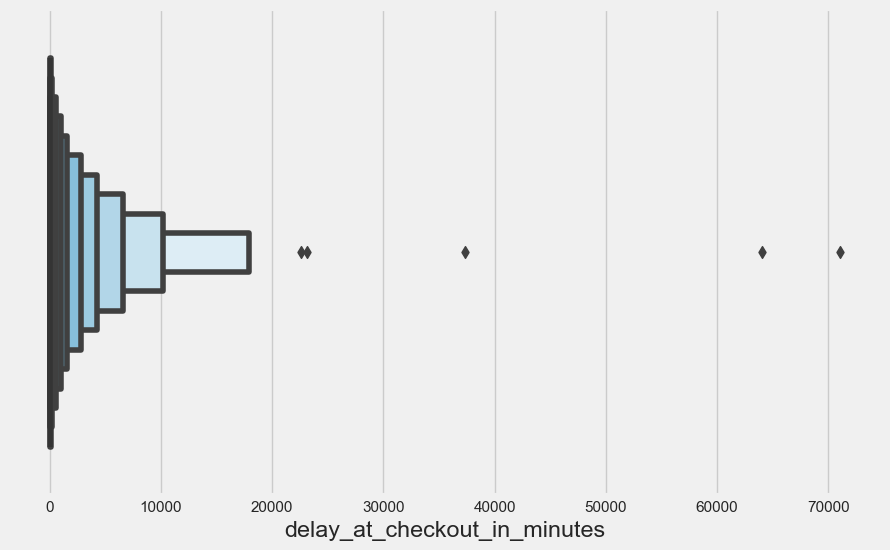

In [61]:
plt.figure(figsize=(10,6))
sns.boxenplot(data=delay_df[delay_df['checkout']!='Early'], x='delay_at_checkout_in_minutes',scale='linear')
plt.show()

Nous constatons que nous avaons des valeurs erronées ou aberrantes avec comme valeur max = 71084 minutes. Nous allons essayer de traiter ces outliers en les remplaçants par des valeurs manquantes NaN.

In [62]:
delayed = []
for x in delay_df['delay_at_checkout_in_minutes']:
    if x < delay_df['delay_at_checkout_in_minutes'].quantile(0.01):
        delayed.append(np.nan)
    elif x > delay_df['delay_at_checkout_in_minutes'].quantile(0.99):
        delayed.append(np.nan)     
    else:
        delayed.append(x)

delay_df['delays_checkout_min_clean'] = delayed

In [63]:
print("Basics statistics: ")
data_desc = delay_df.describe(include='all')
display(data_desc)
print()
with pd.option_context('display.max_colwidth', None):
    display(docu)
    print()

print("Percentage of missing values: ")

pd.concat([delay_df.isnull().sum(), 100 * delay_df.isnull().sum()/len(delay_df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

Basics statistics: 


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,checkout,delays_checkout_min_clean
count,21310.000000,21310.000000,21310,21310,16346.000000,1841.000000,1841.000000,16346,16019.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN,6,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN,Early,NaN
freq,NaN,NaN,17003,18045,NaN,NaN,NaN,6820,NaN
mean,549712.880338,350030.603426,NaN,NaN,59.701517,550127.411733,279.288430,NaN,31.599600
std,13863.446964,58206.249765,NaN,NaN,1002.561635,13184.023111,254.594486,NaN,215.203776
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,505628.000000,0.000000,NaN,-853.000000
25%,540613.250000,317639.000000,NaN,NaN,-36.000000,540896.000000,60.000000,NaN,-35.000000
50%,550350.000000,368717.000000,NaN,NaN,9.000000,550567.000000,180.000000,NaN,9.000000
75%,560468.500000,394928.000000,NaN,NaN,67.000000,560823.000000,540.000000,NaN,65.000000


,field name,Comment
0,rental_id,Unique identifier of the rental
1,car_id,Unique identifier of the car
2,checkin_type,"Flow used for both checkin and checkout. (ie. access and return the car)\nmobile = rental agreement signed on the owner's smartphone\nconnect = car equiped with the Connect technology , opened by the driver with his smartphone.\nNote: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case"
3,state,canceled means that the rental did not happen (was canceled by the driver or the owner).
4,delay_at_checkout_in_minutes,Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
5,previous_ended_rental_id,id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
6,time_delta_with_previous_rental_in_minutes,"Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)"



Percentage of missing values: 


,Missing Records,Percentage (%)
rental_id,0,0.000000
car_id,0,0.000000
checkin_type,0,0.000000
state,0,0.000000
delay_at_checkout_in_minutes,4964,23.294228
previous_ended_rental_id,19469,91.360863
time_delta_with_previous_rental_in_minutes,19469,91.360863
checkout,4964,23.294228
delays_checkout_min_clean,5291,24.828719


In [64]:
print(delay_df['checkout'].value_counts())

checkout
Early              6820
Late > 2 hours     2568
Late 0-15 mins     2003
Late 1-2 hours     1860
Late 30-60 mins    1722
Late 15-30 mins    1373
Name: count, dtype: int64


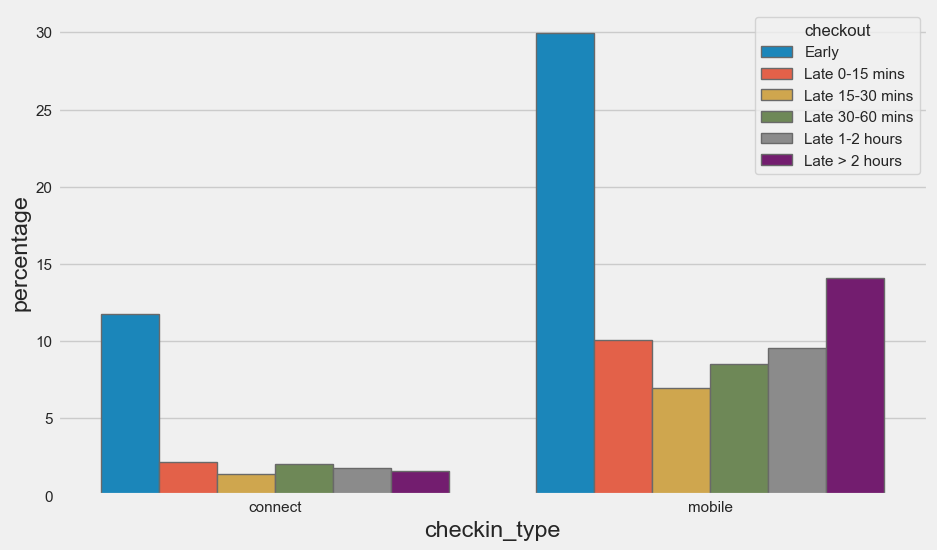

In [65]:
checkout_clean = delay_df.dropna(subset=['delay_at_checkout_in_minutes'])
checktype_checkout = checkout_clean.groupby(['checkin_type','checkout']).size().reset_index(name='count')
checktype_checkout['percentage'] = [i / checktype_checkout['count'].sum() * 100 for i in checktype_checkout['count']]

plt.figure(figsize=(10,6))
sns.barplot(y=checktype_checkout['percentage'],x=checktype_checkout['checkin_type'], hue=checktype_checkout['checkout'],orient='vertical')
plt.show()

La majorité des départs en retard sont toujours dans les 2 prochaines heures, nous pourrons donc probablement reduire les risques de retard de location en fixant un seuil.

Le type de checkin mobile est plus fréquent.

In [66]:
delay_df['next_rental'] = [True if x > 0 else False for x in delay_df.previous_ended_rental_id]

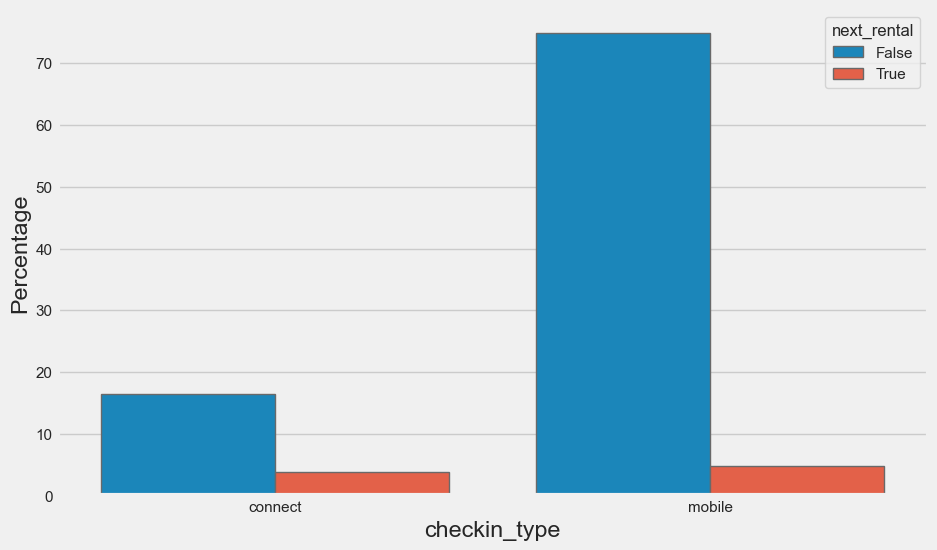

In [67]:
has_next = delay_df.groupby(['checkin_type','next_rental']).size().reset_index(name='count')
has_next['Percentage'] = [i / has_next['count'].sum() * 100 for i in has_next['count']]

plt.figure(figsize=(10,6))
sns.barplot(y=has_next['Percentage'],x=has_next['checkin_type'], hue=has_next['next_rental'],orient='vertical')
plt.show()

In [68]:
connect_share = (delay_df['checkin_type'].value_counts()/delay_df['checkin_type'].count()*100)[1]
mobile_share = (delay_df['checkin_type'].value_counts()/delay_df['checkin_type'].count()*100)[0]
connect_canceled = (delay_df[delay_df['state']=='canceled']['checkin_type'].value_counts()/delay_df[delay_df['state']=='canceled']['checkin_type'].count()*100)[1]

print(f"Le checking par Mobile est plus utilisé avec {round(mobile_share,2)}% de pourcentage alors le checking par Connect a {round(connect_share,2)}% de pourcentage d'utilisation. \n On note que {round(connect_canceled)}% des annulations concernent Connect, ce qui suggère un impact plus important des annulations sur ce type ce type de location.")

Le checking par Mobile est plus utilisé avec 79.79% de pourcentage alors le checking par Connect a 20.21% de pourcentage d'utilisation.        On note que 24% des annulations concernent Connect, ce qui suggère un impact plus important des annulations sur ce type ce type de location.


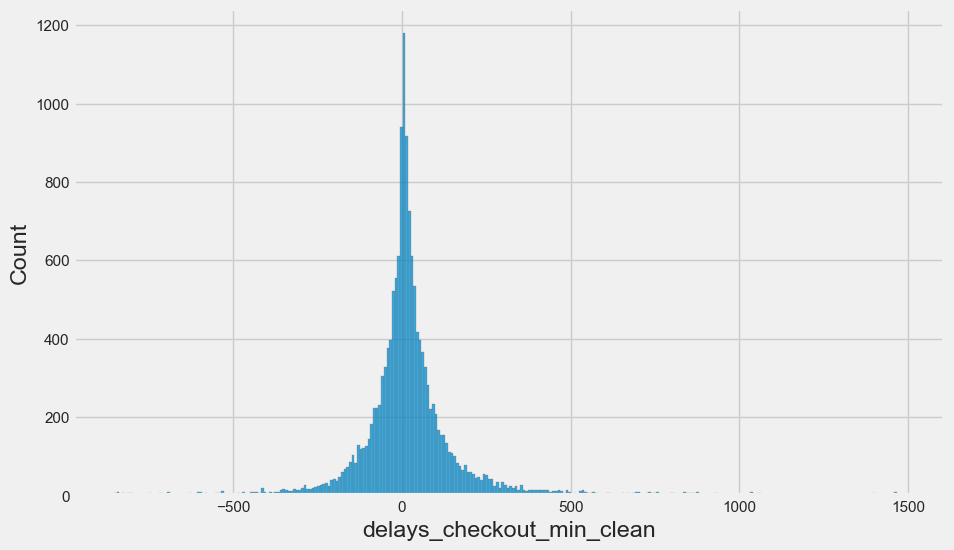

In [69]:
plt.figure(figsize=(10,6))
sns.histplot(data=delay_df,x='delays_checkout_min_clean')
plt.show()

Nous constatons toujours assez de outiliers.

In [70]:
overdue_df = delay_df[delay_df['delays_checkout_min_clean']>0]

drivers_overdue = len(overdue_df)
drivers_total = len(delay_df)
percentage_drivers_late = drivers_overdue/drivers_total*100
percentage_drivers_late
print(f"En moyenne, {round(percentage_drivers_late,2)} % des réservations sont en retard, soit {drivers_overdue} réservations sur {drivers_total}.")

En moyenne, 43.36 % des conducteurs sont en rate, soit 9240 conducteurs sur 21310.


In [71]:
time_overdue = overdue_df['delays_checkout_min_clean'].sum()/len(overdue_df)
print(f"La moyenne de retard sur les réservations est de {round(time_overdue,2)} minutes.")

La moyenne de reatrd des conducteurs est de 124.32 minutes.


Verifiions le par le graphique suivant:

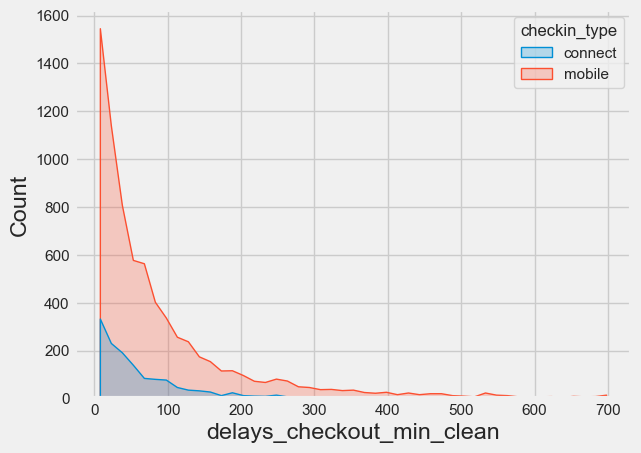

In [72]:
sns.histplot(data=overdue_df, x="delays_checkout_min_clean", hue="checkin_type", element="poly", bins=np.arange(0, 60*12, step=15)) ## (60*12) for 12 hours
plt.show()

### Quelles sont les pertes entrainées par ces retards ?

In [92]:
overdue_df_connect = overdue_df[overdue_df["checkin_type"] == "connect"]
overdue_df_mobile = overdue_df[overdue_df["checkin_type"] == "mobile"]
overdue_median_connect = np.median(overdue_df_connect["delays_checkout_min_clean"])
overdue_median_mobile = np.median(overdue_df_mobile["delays_checkout_min_clean"])

### Reservations annulées

In [103]:
canceled = (delay_df['state'] == 'canceled').sum()
median_rental = pricing_df['rental_price_per_day'].median()
canceled_loss = canceled*median_rental 

print(f"En supposant une moyenne de location de 24 heures et en prenant une durée moyenne de location de 24h, les {canceled} annulations ont engrangé {canceled_loss}$ de perte.")
print("En supposant bien sûr que ces annulations sont exclusivement liées aux rétards de précedentes réservations.")

En supposant une moyenne de location de 24 heures et en prenant une durée moyenne de location de 24h, les 3265 annulations ont engrangé 388535.0$ de perte.
En supposant bien sûr que ces annulations sont exclusivement liées aux rétards de précedentes réservations.


### Avec le checkin Connect

In [98]:
nb_overdues = len(overdue_df_connect)
print(f"{nb_overdues} réservations sont impactées par les retards avec le mode Connect.")
overdue_median_connect = np.median(overdue_df_connect["delays_checkout_min_clean"])
print(f"Le retard est d'environ : {overdue_median_connect} minutes")
med_price_rent_by_day = np.median(pricing_df["rental_price_per_day"]) ## price by day
avg_price_rent_by_min = med_price_rent_by_day / 1440  # 1440 represente le nombre de minutes par jour.
print(f"Sachant que la prix moyen de location d'une voiture est d'environ : {round(med_price_rent_by_day,2)}$ par jour, on tourne autour de : {round(avg_price_rent_by_min, 3)}$/min.")
lost_cash = avg_price_rent_by_min * overdue_median_connect
print(f"L'entreprise perdrait donc environ {round(lost_cash, 3)}$/retard, ce qui répresente {round((lost_cash * nb_overdues), 2)}$ pour les {nb_overdues} retards.")

1459 réservations sont impactées par les retards avec le mode Connect.
Le retard est d'environ : 41.0 minutes
Sachant que la prix moyen de location d'une voiture est d'environ : 119.0$ par jour, on tourne autour de : 0.083$/min.
L'entreprise perdrait donc environ 3.388$/retard, ce qui répresente 4943.38$ pour les 1459 retards.


### Avec le checkin Mobile

In [99]:
nb_overdues = len(overdue_df_mobile)
print(f"{nb_overdues} réservations sont impactées par les retards avec le mode Mobile.")
overdue_median_mobile = np.median(overdue_df_mobile["delays_checkout_min_clean"])
print(f"Le retard est d'environ : {overdue_median_mobile} minutes")
med_price_rent_by_day = np.median(pricing_df["rental_price_per_day"]) ## price by day
avg_price_rent_by_min = med_price_rent_by_day / 1440  # 1440 represente le nombre de minutes par jour.
print(f"Sachant que la prix moyen de location d'une voiture est d'environ : {round(med_price_rent_by_day,2)}$ par jour, on tourne autour de : {round(avg_price_rent_by_min, 3)}$/min.")
lost_cash = avg_price_rent_by_min * overdue_median_mobile
print(f"L'entreprise perdrait donc environ {round(lost_cash, 3)}$/retard, ce qui répresente {round((lost_cash * nb_overdues), 2)}$ pour les {nb_overdues} retards.")

7781 réservations sont impactées par les retards avec le mode Connect.
Le retard est d'environ : 54.0 minutes
Sachant que la prix moyen de location d'une voiture est d'environ : 119.0$ par jour, on tourne autour de : 0.083$/min.
L'entreprise perdrait donc environ 4.462$/retard, ce qui répresente 34722.71$ pour les 7781 retards.


Avec ces resultats , nous constatons que l'entreprise perd beaucoup plus d'argent avec le checkin Mobile et surtotu que les annulations entrainent également de grosses pertes.